# Overvew
- [Freesound 7th place solution](https://www.kaggle.com/hidehisaarai1213/freesound-7th-place-solution) にあった、Strength Adaptive Cropをためす

# CONST

In [69]:
NB = '034'
DEBUG = False
PERIOD = 5
PATH_EVENT = './../data_ignore/event/nb017_event_rms/nb017_event_rms.csv'
DIR_EVENT = './../data_ignore/event/'
DATASET = '32khz'
DIR_MODEL = './../data_ignore/model'
PATH_MODEL = './../data_ignore/model/resnest50/resnest50_fast_1s1x64d-d8fbf808.pth'

In [2]:
settings_str = """
globals:
  seed: 1213
  device: cuda
  num_epochs: 45
  output_dir: /kaggle/training_output/
  use_fold: 0
  target_sr: 32000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 224
    melspectrogram_parameters:
      n_mels: 128
      fmin: 20
      fmax: 16000
    
split:
  name: StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 50
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 50
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: resnest50_fast_1s1x64d
  params:
    pretrained: True
    n_classes: 264

loss:
  name: BCEWithLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [73]:
import os
import gc
import typing as tp
import pickle
import logging
import cv2 
import warnings
import math
import time
import yaml
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from fastprogress import progress_bar
from contextlib import contextmanager
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

# import torch
# import torch.nn as nn
# # from torchvision import models
# import torch.nn.functional as F
# import torch.utils.data as data
# import resnest.torch as resnest_torch
# from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
# from torch.nn.modules.utils import _pair

# import sys
# sys.path.insert(0, './../src/util/')
# from const import BIRD_CODE, INV_BIRD_CODE

# My function

In [4]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

# Preparation

settings

In [5]:
pd.set_option('display.max_columns', 100)

In [6]:
settings = yaml.safe_load(settings_str)
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

for k, v in settings.items():
    print("[{}]".format(k))
    print(v)
# set_seed(settings["globals"]["seed"])

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 45, 'output_dir': '/kaggle/training_output/', 'use_fold': 0, 'target_sr': 32000}
[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'fmin': 20, 'fmax': 16000}}}
[split]
{'name': 'StratifiedKFold', 'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}}
[loader]
{'train': {'batch_size': 50, 'shuffle': True, 'num_workers': 10, 'pin_memory': True, 'drop_last': True}, 'val': {'batch_size': 50, 'shuffle': False, 'num_workers': 10, 'pin_memory': True, 'drop_last': False}}
[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 264}}
[loss]
{'name': 'BCEWithLogitsLoss', 'params': {}}
[optimizer]
{'name': 'Adam', 'params': {'lr': 0.001}}
[scheduler]
{'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}


<br>

data path

In [7]:
root = Path.cwd().parent
input_ex_root = root / 'data_ignore/external_dataset' / DATASET
train_resampled_audio_dirs = [input_ex_root / "birdsong-resampled-train-audio-{:0>2}"
                              .format(i)  for i in range(5)]

In [8]:
train_resampled_audio_dirs

[PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-00'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-01'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-02'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-03'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-04')]

<br>

load data

In [9]:
train = pd.read_csv(train_resampled_audio_dirs[0] / "train_mod.csv")

# Execution

<br>

train_all を作成  
train_all: リサンプル後のファイルパスなどを追加

In [10]:
tmp_list = []
for audio_d in train_resampled_audio_dirs:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for i, wav_f in enumerate(ebird_d.iterdir()):
            bool_n_splits = i==settings['split']['params']['n_splits']
            if bool_n_splits and DEBUG: break  # if DEBUG=True: 1bird/n_splits file
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

if DEBUG: print('----- debug mode -----')
print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


In [11]:
file_list = train_all['file_path'].values.tolist()

# Execute
- Strength Adaptive Cropが思った動作をしなかったので、spectrogramの500~16000Hzを足し上げることにした。

/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-00/aldfly/XC135459.wav


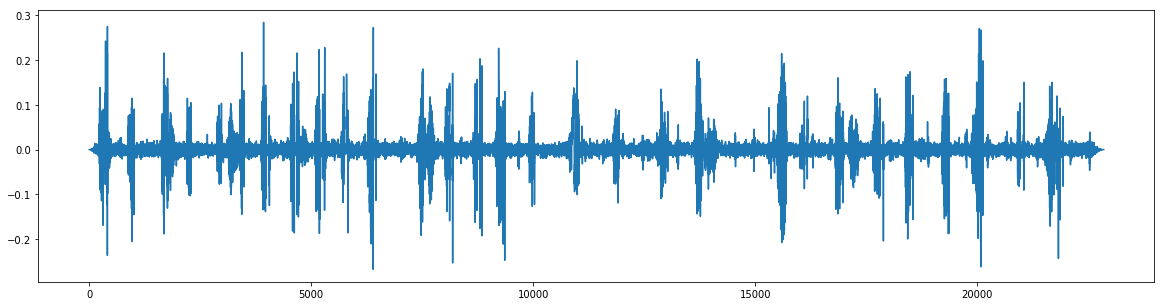

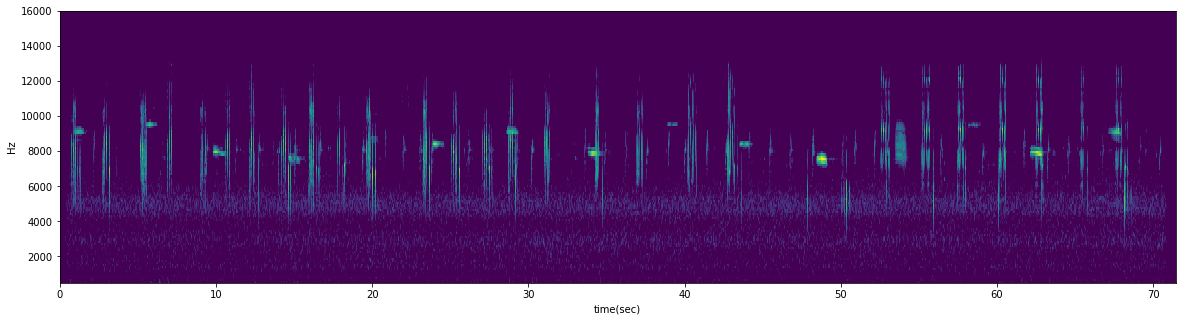

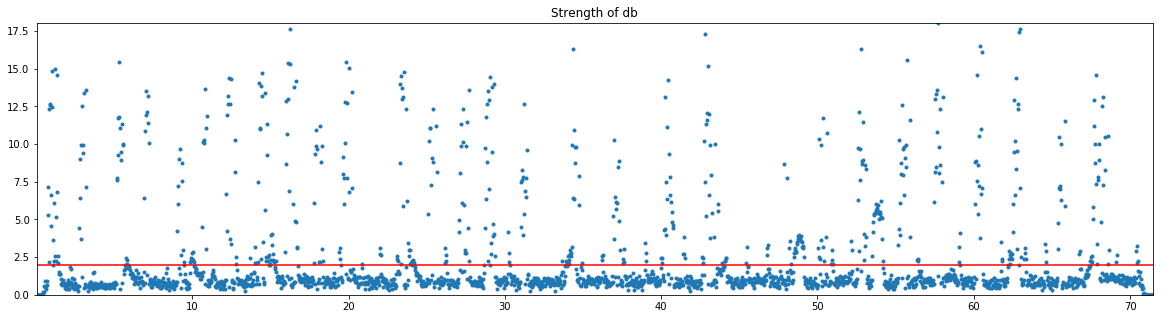

In [66]:
idx = 5

# n_fft = int(sr*0.5)
# n_fft = 4096
sr = 32000
thresh = 2
n_fft = 2048
# n_fft = 512
hop_length = int(n_fft/2)
hop_length_sec = hop_length / sr
fmin = 500
fmax = 16000

print(file_list[idx])
# signal, _ = librosa.load(file_list[idx])
signal, sr = sf.read(file_list[idx])
spec = librosa.feature.melspectrogram(signal, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax)
spec = librosa.amplitude_to_db(spec)
end_sec = (len(signal) + hop_length) / sr

x = np.linspace(0, len(signal), len(spec[1]))/sr + hop_length_sec
y = np.sum(spec, axis=0)
y = y - np.min(y)
med = np.median(y) + 10e-7

plt.figure(figsize=(20, 5))
plt.plot(signal[::100])

plt.figure(figsize=(20, 5))
plt.imshow(spec, aspect='auto', origin='lower', cmap=None, extent=(0, end_sec, fmin, fmax))
plt.xlabel('time(sec)')
plt.ylabel('Hz')

plt.figure(figsize=(20, 5))
plt.title('Strength of db')
plt.plot(x, y/med, '.')
plt.axhline(2, color='r')
plt.margins(0) 

# Create event dataframe
- 以下のようなデータフレームを作成(pickleで保存)
- カラムは3つ、event_sec_list, n_event, filename

In [44]:
sr = 32000
thresh = 2
n_fft = 2048
# n_fft = 512
hop_length = int(n_fft/2)
hop_length_sec = hop_length / sr
fmin = 500
fmax = 16000

In [67]:
df_event_intensity = pd.DataFrame(columns=['event_sec_list', 'n_event', 'filename'])
for idx in progress_bar(range(len(file_list))):
    wav_path = file_list[idx]
    basename = os.path.basename(wav_path)
    
#     signal, _ = librosa.load(wav_path)
    signal, sr = sf.read(wav_path)
    
    # melspectrogram
    spec = librosa.feature.melspectrogram(signal, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax)
    spec = librosa.amplitude_to_db(spec)

    # intensity
    intensity = np.sum(spec, axis=0)
    intensity = intensity - np.min(intensity)
    med = np.median(intensity) + 10e-7
    
    # x_sec
    x_sec = np.linspace(0, len(signal), len(spec[1]))/sr + hop_length_sec
    
    # mask
    mask = intensity/med > thresh
    
    # event
    event_sec_list = x_sec[mask]
    
    # append
    df_event_intensity = df_event_intensity.append({
            'event_sec_list': event_sec_list.astype('float16'),
            'n_event': len(event_sec_list),
            'filename': basename}, 
            ignore_index=True)

# Save

In [70]:
event_name = 'event_intensity_500to16000hz'
save_dir = f'{DIR_EVENT}nb{NB}_{event_name}/'
file_dir = os.path.dirname(save_dir)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)
file_dir 

'./../data_ignore/event/nb034_event_intensity_500to16000hz'

In [71]:
save_path = f'{file_dir}/nb{NB}_{event_name}.pickle'
save_path

'./../data_ignore/event/nb034_event_intensity_500to16000hz/nb034_event_intensity_500to16000hz.pickle'

In [74]:
if not DEBUG:
#     df_event_sec.to_csv(save_path, index=False)
    with open(save_path, mode='wb') as f:
        pickle.dump(df_event_intensity, f)
    print('perform save')

perform save


In [92]:
df_event_intensity.head(20)

,event_sec_list,n_event,filename
0,"[1.473, 1.505, 2.914, 2.945, 2.979, 3.01, 3.04...",281,XC134874.wav
1,"[0.4802, 0.512, 0.5444, 0.9604, 0.9927, 1.024,...",325,XC135454.wav
2,"[0.416, 0.448, 0.48, 0.544, 0.576, 0.608, 0.64...",506,XC135455.wav
3,"[0.4482, 0.4802, 0.512, 0.5444, 1.089, 1.121, ...",427,XC135456.wav
4,"[0.1921, 0.2241, 1.793, 4.29, 4.324, 4.355, 9....",99,XC135457.wav
5,"[0.2242, 1.313, 1.858, 2.018, 2.05, 2.371, 2.7...",18,XC135459.wav
6,"[0.128, 0.16, 0.1921, 0.2241, 0.256, 0.64, 0.6...",611,XC135460.wav
7,"[0.288, 0.384, 0.672, 0.8643, 0.928, 1.024, 1....",731,XC135883.wav
8,"[0.8003, 2.145, 2.178, 2.209, 2.24, 2.273, 2.3...",190,XC137570.wav
9,"[0.256, 0.288, 0.32, 0.352, 0.384, 0.416, 0.44...",90,XC138639.wav
